# COMP24112 Summative Exercise: Air Quality Analysis (30 Marks)

This lab exercise is about air quality analysis, where you will predict air quality through solving classification and regression tasks. You will submit a notebook file, a pdf report, and a trained model. You will be marked for implementation, design, result and analysis. Your code should be easy to read and your report should be concise (max 600 words). It is strongly recommended that you use a LaTeX editor, such as [Overleaf](https://www.overleaf.com/), to write your report.

Please note your notebook should take no more than 10 minutes to run on lab computers. **There is 1 mark for code efficiency.**

## 1. Dataset and Knowledge Preparation

The provided dataset contains measurements of air quality from a multisensor device. The device used spectrometer analyzers (variables marked by "GT") and solid state metal oxide detectors (variables marked by "PT08.Sx"), as well as temperature (T), relative humidity (RH) and absolute humidity (AH) sensors. 

The dataset contains 3304 instances of hourly averaged measurements taken at road level in a polluted city. You will predict the CO(GT) variable representing carbon monoxide levels. There are missing features in this dataset, flagged by the number `-999`. 

You will need to pre-process the dataset to handle missing features, for which please self-learn from scikit-learn on how to [impute missing values](https://scikit-learn.org/stable/modules/impute.html). You will need to split the dataset into training and testing sets, also to run cross validation, when you see fit. For this, please self-learn from scikit-learn on [data splitting](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html).   

In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import sklearn.model_selection

notebook_start_time = time.time()

# Import data - it should be saved in the same root directory as this notebook
sensor_data_full = pd.read_excel('sensor_data.xlsx')

# Display a sample of the data
sensor_data_full.sample(5)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
2605,2.0,1031.50,12.609400,1070.50,127.0,742.25,131.0,1619.25,840.0,35.724999,18.875000,1.086502
2400,1.0,934.75,4.233620,723.50,43.0,936.00,49.0,1574.25,597.5,29.525000,45.925000,1.866170
814,0.7,830.25,2.328647,607.75,33.0,1281.50,41.0,1369.75,441.0,18.625000,52.324999,1.112058
508,2.9,1374.50,14.524226,1133.50,518.1,503.75,140.6,1466.75,1469.5,8.725000,61.625001,0.696050
1318,1.1,1043.50,2.657093,630.00,160.1,845.25,118.5,1098.75,808.5,11.775000,67.900002,0.936196


## 2. Linear Classification via Gradient Descent (13 marks)

The air quality is assessed using the CO(GT) variable. If it is no greater than 4.5, the air quality is good (CO(GT)<=4.5), otherwise, it is bad  (CO(GT)>4.5). You will perform binary classification to predict whether the air quality is good based on the other 11 varivables, i.e., from PT08.S1(CO) to AH. 

### 2.1 Model Training and Testing (4 marks)

This practice is about training a binary linear classifier by minimising a hinge loss with L2 (ridge) regularisation, and then testing its performance. Given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where $\mathbf{x}_i$ is the feature vector and $y_i \in \{-1, +1\}$ is the class label for the $i$-th training sample, the training objective function to minimise is 
$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$
Here, $\mathbf{w}$ is a column weight vector of the linear model, $w_0$ is the bias parameter of the model, and $C$ is the regularisation hyperparameter.

Recall from your lectures that gradient descent is an iterative optimisation algorithm typically used in model training. Complete the implmentation of the training function `linear_gd_train` below, which trains your linear model by minimising the above provided training objective function $O$ using gradient descent.

The function should return the trained model weights and the corresponding objective function value (referred to as cost) per iteration. In addition to the training data, the function should take the regularisation hyperparameter $C$, learning rate $\eta$, and the number of iterations $N_{max}$ as arguments. A default setting of these parameters has been provided below, which is able to provide reasonably good performance.  

**Note that scikit-learn is not allowed for implementation in this section.** We recommend that you avoid using `for` loops in your implementation of the objective function or weight update, and instead use built-in numpy operations for efficiency. 

In [17]:
def linear_gd_train(data, labels, c=0.2, n_iters=200, learning_rate=0.001, random_state=None  # Add any other arguments here if needed
                    ):
    """
    A summary of your function goes here.

    data: training data
    labels: training labels (boolean)
    c: regularisation parameter
    n_iters: number of iterations
    learning_rate: learning rate for gradient descent
    threshold: threshold to classify the predicted values

    Returns an array of cost and model weights per iteration.
    """
    # Set random seed for reproducibility if using random initialisation of weights (optional)
    rng = np.random.default_rng(seed=random_state)

    # Create design matrix and labels
    X_tilde = np.hstack((np.ones((data.shape[0], 1)), data))
    y = labels.astype(int) * 2 - 1

    # Weight initialisation: use e.g. rng.standard_normal() or all zeros
    w = rng.standard_normal(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = []
    cost_all = []

    # GD update of weights
    for i in range(n_iters):

        # Predicted label value
        f = np.dot(X_tilde, w)

        # Hinge loss function value
        hl = np.maximum(0, 1 - y * f)

        # Regularisation cost value
        reg_cost = np.dot(w, w) / 2

        # Cost and gradient update of the linear model
        cost = c * np.sum(hl) + reg_cost
        
        m = y * f < 1
        grad = -np.dot(X_tilde . T, np.where(m, 1, 0) * y) + w

        # Weight update
        w -= learning_rate * grad

        # save w and cost of each iteration in w_all and cost_all
        cost_all.append(cost)
        w_all.append(w.copy())

    # Return model parameters.
    return np.array(cost_all), np.array(w_all)


def linear_predict(data, w):
    """
    A summary of your function goes here.

    data: test data
    w: model weights

    Returns the predicted labels.
    """

    X_tilde = np.hstack((np.ones((data.shape[0], 1)), data))
    y_pred = np.dot(X_tilde, w . T)

    return y_pred > 0

Now, you are ready to conduct a complete experiment of air quality classification. The provided code below splits the data into training and testing sets and imputes the missing features. 

In [18]:
from sklearn.impute import SimpleImputer

# Put a threshold on the labels to cast to binary: True if CO(GT) > 4.5, False otherwise
binary_targets = (sensor_data_full['CO(GT)'] > 4.5).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15, stratify=binary_targets)

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)

Write your code below, which should train the model, plot the training objective function value and the classification accuracy of the training set over iterations, and print the classification accuracy and $F_1$ score of the testing set. Note, use the default setting provided for $C$, $\eta$ and $N_{max}$. Your plot should have axis labels and titles.

In [19]:
# Train the model
costs, trained_weights = linear_gd_train(train_X_cls, train_y_cls)
pred_train_1 = linear_predict(train_X_cls, trained_weights)
pred_train_1 = pred_train_1 . T
np.mean(pred_train_1 == train_y_cls)

0.9553668091168092

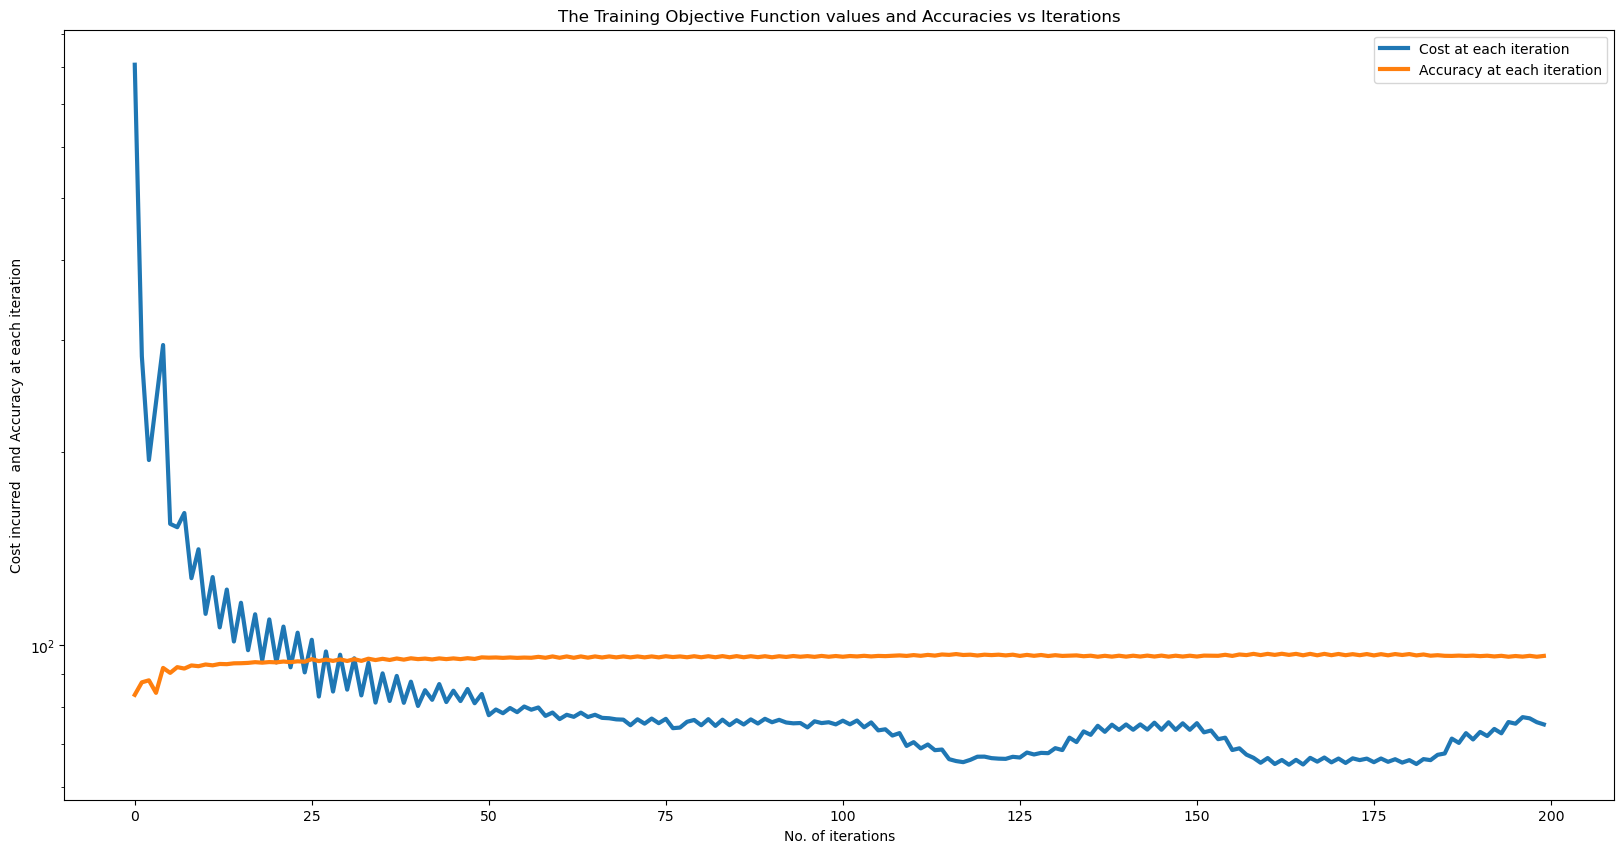

In [20]:
# Plot accuracy and cost per iteration on training set
accuracies = []
for w in trained_weights:
    pred_y = linear_predict(train_X_cls, w) . T
    accuracies.append(np.mean(pred_y == train_y_cls) * 100)

plt.figure(figsize=(20, 10))
plt.plot(costs, label="Cost at each iteration", linewidth=3)
plt.plot(accuracies, label="Accuracy at each iteration", linewidth=3)
plt.title("The Training Objective Function values and Accuracies vs Iterations")
plt.xlabel("No. of iterations")
plt.ylabel("Cost incurred  and Accuracy at each iteration")
plt.yscale("log")
plt.legend()

In [21]:
# Apply imputation to the test set
test_X_cls = imputer.fit_transform(test_X_cls)
test_X_cls = scaler.fit_transform(test_X_cls)

In [22]:
# Predict on test set, report accuracy and f1 score
pred_test = linear_predict(test_X_cls, trained_weights) . T
accuracy_test = np.mean(pred_test == test_y_cls)
accuracy_test

0.9590221774193548

In [23]:
def f1_score_calc(y_true, y_pred):
    f1_scores = []
    for y in y_pred:
        n_true_pos = sum(1 for i in range(200) if y_true[i] == y[i] == True)
        n_pred_pos = sum(1 for i in range(200) if y[i] == True)
        n_actual_pos = sum(1 for i in range(200) if y_true[i] == True)

        prec = n_true_pos / n_pred_pos if n_pred_pos > 0 else 0
        rec = n_true_pos / n_actual_pos if n_actual_pos > 0 else 0

        f1_scores.append(2 * prec * rec / (prec + rec) if prec > 0 and rec > 0 else 0)
    
    return np.mean(f1_scores)

In [24]:
# F1 score of the testing values
f1_score = f1_score_calc(test_y_cls, pred_test)
f1_score

0.5610738914671017

### 2.2 Learning Rate Analysis (3 marks)

The learning rate $\eta$ (Greek letter "eta") is a key parameter that affects the model training and performance. Design an appropriate experiment to demonstrate the effect of $\eta$ on model training, and on the model performance during testing.

In [25]:
# Your code here
learning_rate_accuracies = []
learning_rate_train_accuracies = []
costing_learning_rate = []
f1_scores = []
# Learning rate values from  0 to 1 with step value 0.001
learning_rate_values = [i * 0.0001 for i in range(1, 101, 1)]

In [26]:
for lr in learning_rate_values:
    cost_lr, weights_lr = linear_gd_train(
        train_X_cls, train_y_cls, learning_rate=lr)
    pred_y_value_lr = linear_predict(test_X_cls, weights_lr) . T
    pred_x_value_lr = linear_predict(train_X_cls, weights_lr) . T
    accuracy_lr = np.mean(test_y_cls == pred_y_value_lr)
    accuracy_tlr = np.mean(train_y_cls == pred_x_value_lr)

    f1_score = f1_score_calc(test_y_cls, pred_y_value_lr)

    learning_rate_accuracies.append(accuracy_lr)
    learning_rate_train_accuracies.append(accuracy_tlr)
    f1_scores.append(f1_score)

In [27]:
default_lr = 0.001
max_train_acc = max(learning_rate_train_accuracies)
best_train_lr = learning_rate_values[
    learning_rate_train_accuracies.index(max_train_acc)]
accuracy_def_train_lr = learning_rate_train_accuracies[learning_rate_values.index(
    default_lr)]

accuracy_def_lr = learning_rate_accuracies[learning_rate_values.index(
    default_lr)]
max_accuracy = max(learning_rate_accuracies)
best_lr = learning_rate_values[learning_rate_accuracies.index(max_accuracy)]

In [28]:
print(f"Highest training accuracy achieved: {max_train_acc * 100:0.6f}%")
print(f"Highest testing accuracy achieved: {max_accuracy * 100:0.6f}%")

Highest training accuracy achieved: 96.833868%
Highest testing accuracy achieved: 96.416331%


Text(0.5, 1.0, 'Training and Testing accuracies vs Learning rates')

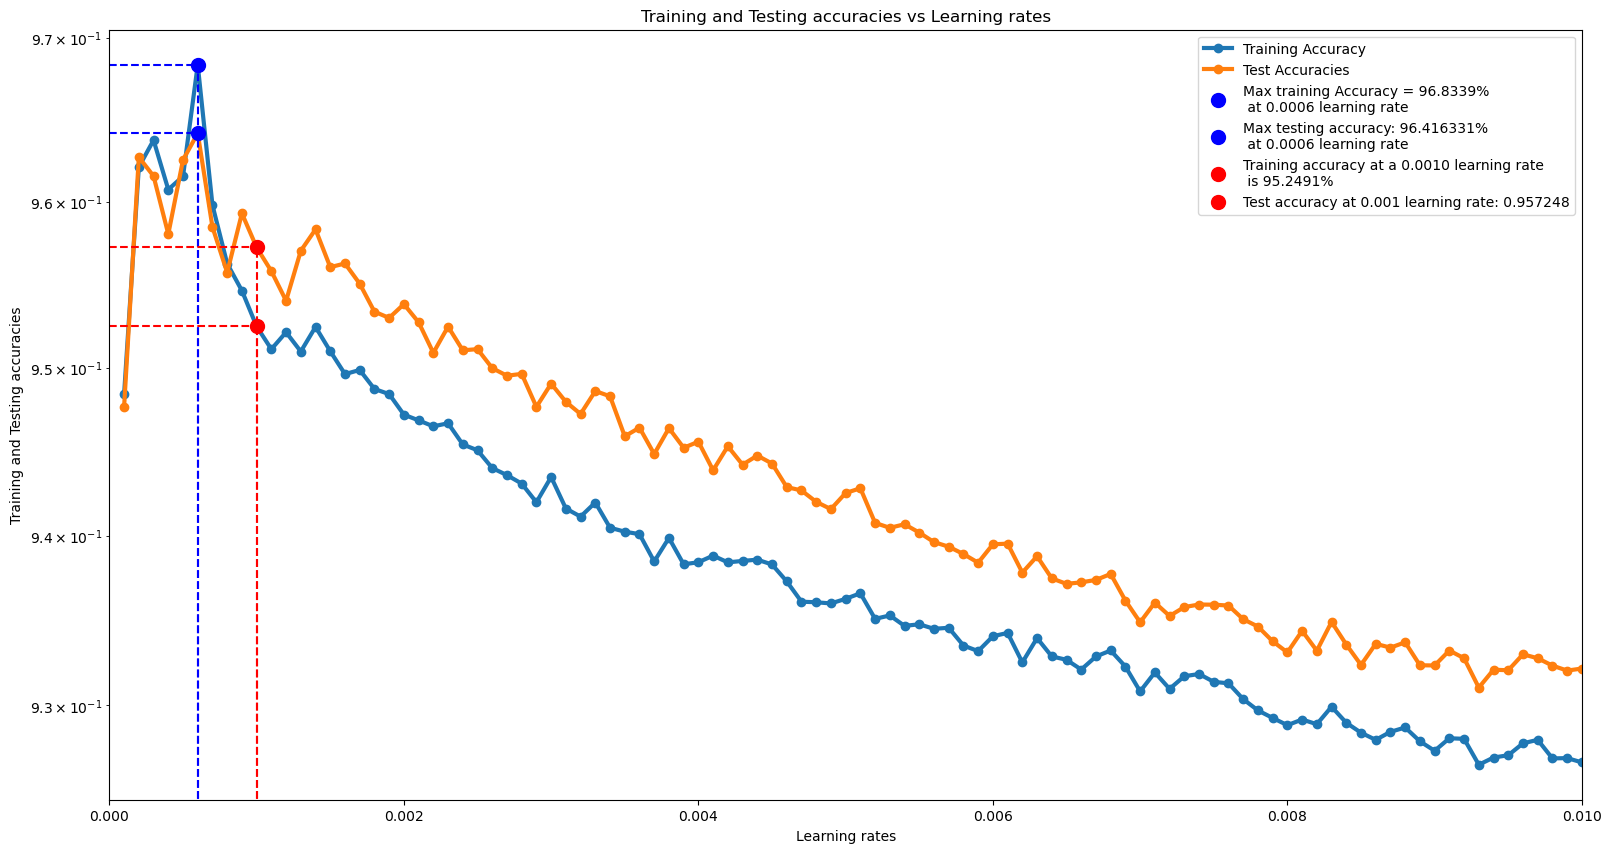

In [29]:
plt.figure(figsize=(19, 10))
plt.plot(np.array(learning_rate_values),
         np.array(learning_rate_train_accuracies), "o-", label=r"Training Accuracy", linewidth=3)
plt.plot(np.array(learning_rate_values),
         np.array(learning_rate_accuracies), "o-", label="Test Accuracies", linewidth=3)

plt.plot(best_train_lr, max_train_acc, "bo", markersize=10,
         label=f"Max training Accuracy = {max_train_acc * 100:.4f}%\n at {best_train_lr:.4f} learning rate")
plt.plot(best_lr, max_accuracy, "bo", markersize=10,
         label=f"Max testing accuracy: {max_accuracy * 100:0.6f}%\n at {best_lr:0.4f} learning rate")

plt.plot(default_lr, accuracy_def_train_lr, "ro", markersize=10,
         label=f"Training accuracy at a {default_lr:.4f} learning rate\n is {accuracy_def_train_lr * 100:.4f}%")
plt.plot(default_lr, accuracy_def_lr, "ro", markersize=10,
         label=f"Test accuracy at {default_lr} learning rate: {accuracy_def_lr:0.6f}")

plt.vlines(default_lr, 0, accuracy_def_train_lr,
           colors='red', linestyles='dashed')
plt.hlines(accuracy_def_train_lr, 0, default_lr,
           colors='red', linestyles='dashed')
plt.vlines(best_train_lr, 0, max_train_acc,
           colors='blue', linestyles='dashed')
plt.hlines(max_train_acc, 0, best_train_lr,
           colors='blue', linestyles='dashed')

plt.vlines(best_lr, 0, max_accuracy,
           colors='blue', linestyles='dashed')
plt.hlines(max_accuracy, 0, best_lr,
           colors='blue', linestyles='dashed')
plt.vlines(default_lr, 0, accuracy_def_lr,
           colors='red', linestyles='dashed')
plt.hlines(accuracy_def_lr, 0, default_lr,
           colors='red', linestyles='dashed')

plt.yscale("log")
plt.xlabel("Learning rates")
plt.xlim(0, learning_rate_values[len(learning_rate_values) - 1])
plt.ylabel("Training and Testing accuracies")
plt.legend()
plt.title("Training and Testing accuracies vs Learning rates")

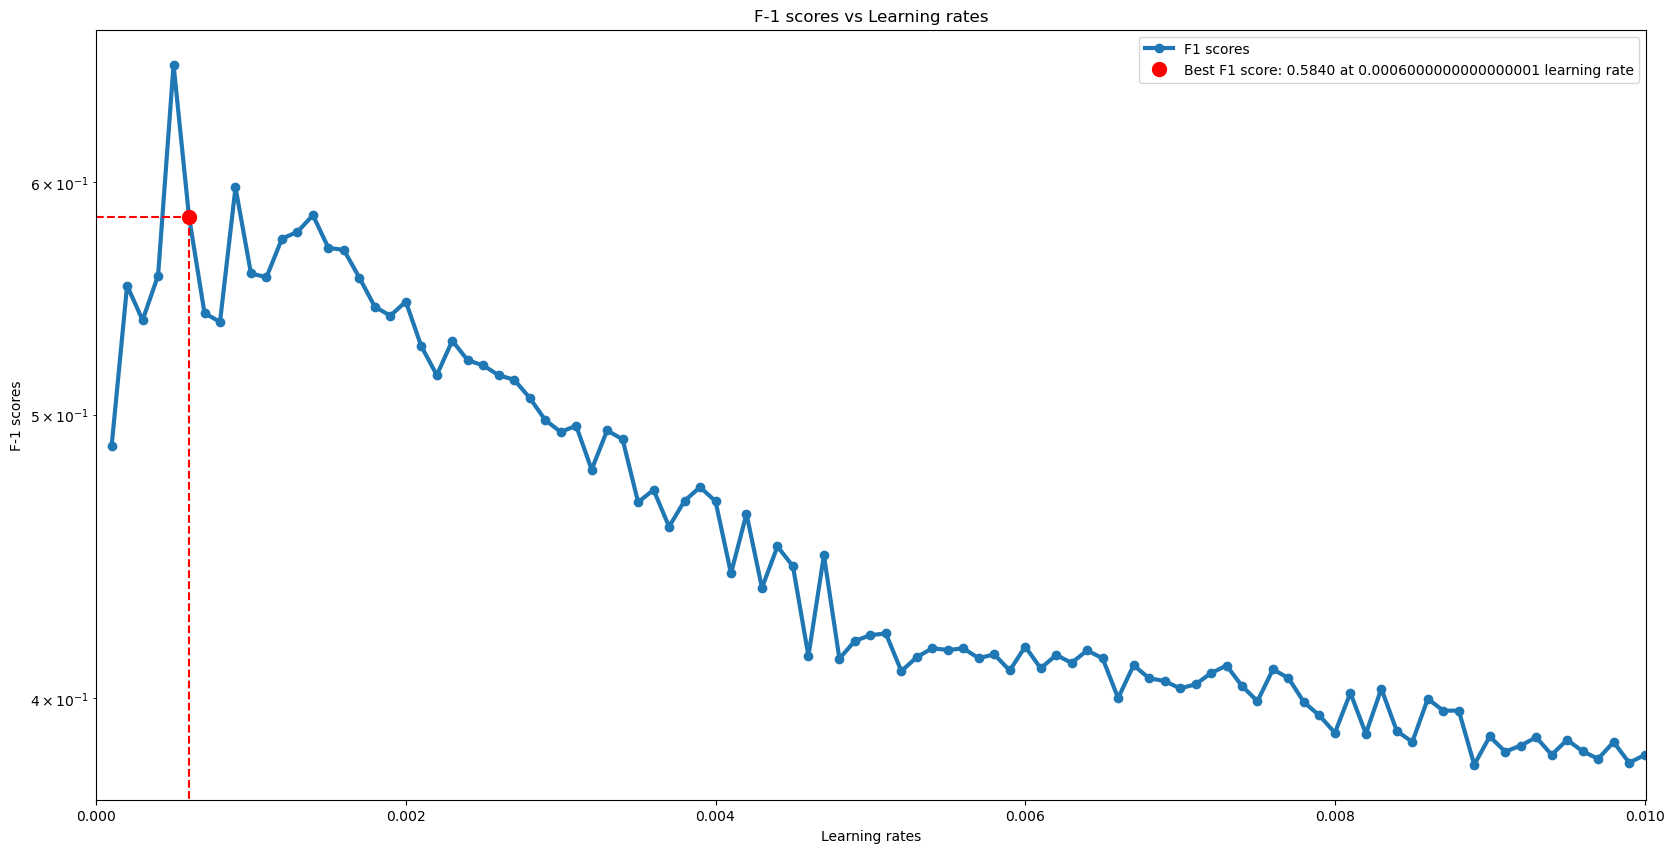

In [30]:
plt.figure(figsize=(20, 10))
best_f1_score = f1_scores[learning_rate_accuracies.index(max_accuracy)]

plt.plot(np.array(learning_rate_values),
         np.array(f1_scores), "o-", label="F1 scores", linewidth=3)

plt.plot(best_lr, best_f1_score,  'ro', markersize=10,
         label=f"Best F1 score: {best_f1_score:0.4f} at {best_lr} learning rate")

plt.yscale("log")
plt.xlim(0, 0.01001)
plt.xlabel("Learning rates")
plt.ylabel("F-1 scores")
plt.legend()
plt.title("F-1 scores vs Learning rates")

plt.vlines(best_lr, 0, best_f1_score,
           colors='red', linestyles='dashed')
plt.hlines(best_f1_score, 0, best_lr,
           colors='red', linestyles='dashed')

### 2.3 Report (6 Marks)
Answer the following questions in your report, to be submitted separately:
1. Derive step-by-step the gradient of the provided training objective function $O$, and the updating equation of your model weights based on gradient descent. (3 marks)

2. What does the figure from section 2.1 tell you, and what is the indication of the classification accuracies of your training and testing sets? (1 mark)

3. Comment on the effect of $\eta$ on model training, and on the model performance during testing, based on your results observed in Section 2.2. (2 marks)

## 3. Air Quality Analysis by Neural Network (10 marks)

In this experiment, you will predict the CO(GT) value based on the other 11 variables through regression. You will use a neural network to build a nonlinear regression model. Familiarise yourself with how to build a regression model by mutlilayer perceptron (MLP) using the scikit learn tutorial (https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression). 


### 3.1 Simple MLP Model Selection (4 marks)

This section is focused on the practical aspects of MLP implementation and model selection. We will first compare some model architectures. 

The set of MLP architectures to select is specified in `param_grid` below, including two MLPs with one hidden layer, where one has a small number of 3 hidden neurons, while the other has a larger number of 100 hidden neurons, and two MLPs with two hidden layers, where one is small (3, 3) and the other is larger (100, 100). It also includes two activation function options, i.e., the logistic and the rectified linear unit ("relu").  These result in a total of 8 model options, where sklearn default parameters are used for all the MLPs and their training. 

In [31]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

param_grid = [
    {   
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
    },
]

Your code below should do the following: Split the dataset into the training and testing sets. Preprocess the data by imputing the missing features. Use the training set for model selection by cross-validation, and use mean squared error (MSE) as the model selection performance metric. You can use the scikit-learn module [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to conduct grid search. Print the cross-validation MSE with standard deviation of the selected model. Re-train the selected model using the whole training set, and print its MSE and $R^2$ score for the testing set.  


In [32]:
# Redo split for regression
# Named _reg to keep our regression experiments distinct from classification
X = sensor_data_full.drop("CO(GT)", axis=1).values
y = sensor_data_full["CO(GT)"].values

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean', verbose=1)
scaler = StandardScaler()

# Prepare the data
imputed_x = imputer.fit_transform(X)
scaled_X = scaler.fit_transform(imputed_x)

train_X_reg, test_X_reg, train_y_reg, test_y_reg = sklearn.model_selection.train_test_split(scaled_X, y, test_size=0.2, random_state=42)

In [33]:
# Define MLP model
model_MLP = MLPRegressor(random_state=42)

In [34]:
# Initialise and fit the grid search
grid = GridSearchCV(model_MLP, param_grid, cv=5, scoring="neg_mean_squared_error")

In [35]:
# Report the best parameters and the CV results
grid.fit(train_X_reg, train_y_reg)

print("Best Parameters: ", grid.best_params_)
print("\n")
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.drop(["params"], axis=1, inplace=True)

/Users/erebus2507/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/erebus2507/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/erebus2507/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/erebus2507/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Best Parameters:  {'activation': 'relu', 'hidden_layer_sizes': (100,)}




In [36]:

cv_results.sort_values(by="rank_test_score", inplace=True)
cv_results.reset_index(drop=True, inplace=True)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.918248,0.006533,0.000623,0.000130,relu,"(100,)",-0.178076,-0.202594,-0.200901,-0.141240,-0.131363,-0.170835,0.029661,1
1,2.289228,0.219625,0.000922,0.000094,relu,"(100, 100)",-0.157511,-0.212713,-0.210877,-0.146838,-0.139952,-0.173578,0.031707,2
2,2.088876,0.263549,0.001354,0.000098,logistic,"(100, 100)",-0.209431,-0.224298,-0.268260,-0.154627,-0.168199,-0.204963,0.040708,3
3,0.941648,0.061581,0.000756,0.000093,logistic,"(100,)",-0.211434,-0.229488,-0.276286,-0.157297,-0.171760,-0.209253,0.042457,4
4,0.526828,0.013613,0.000483,0.000019,relu,"(3, 3)",-0.226474,-0.241357,-0.251815,-0.167641,-0.175078,-0.212473,0.034602,5
5,0.401685,0.014787,0.000462,0.000020,relu,"(3,)",-0.278716,-0.287212,-0.286125,-0.204077,-0.206236,-0.252473,0.038751,6
6,0.513982,0.008439,0.000478,0.000021,logistic,"(3, 3)",-0.500882,-0.364627,-0.578598,-0.331246,-0.403596,-0.435790,0.091281,7
7,0.377767,0.003801,0.000453,0.000024,logistic,"(3,)",-0.670814,-0.450534,-0.733648,-0.452113,-0.552889,-0.572000,0.114356,8


In [37]:
# Report model performance
best_model = grid.best_estimator_
best_model.fit(train_X_reg, train_y_reg)
y_reg_pred = best_model.predict(test_X_reg)
score = grid.best_score_

In [38]:
mse = mean_squared_error(test_y_reg, y_reg_pred)
r_2_score = r2_score(test_y_reg, y_reg_pred)

In [39]:
print("Best model:", best_model)
print("Best score:", score)
print("Mean squared error:", mse)
print("R^2 value:", r_2_score)

Best model: MLPRegressor(random_state=42)
Best score: -0.17083485149521832
Mean squared error: 0.19228459722364016
R^2 value: 0.909912351923374


### 3.2 Training Algorithm Comparison: SGD and ADAM (2 Marks)

In this exercise, you will compare two training algorithms, stochastic gradient descent (SGD) and ADAM optimisation, for training an MLP with two hidden layers each containing 100 neurons with "relu" activation, under the settings specified in `test_params` as below.

In [40]:
test_params = [
    {
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'solver': 'adam'
    },{
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'learning_rate': 'adaptive', 
        'momentum': 0.95, 
        'solver': 'sgd'
    },
]

Write the code below, where each training algorithm should run for 300 iterations (make sure to set `early_stopping=False`). For both algorithms, (1) plot the training loss (use the defaul loss setting in sklearn), as well as the MSE of both training and testing sets, over iterations; and (2) print the MSE and $R^2$ score of the trained model using the testing set. 

In [41]:
# Train models and plot learning curves

# Model 1: ADAM Optimiser MLP
m1 = MLPRegressor(**test_params[0], warm_start=False)

# Model 2: Stochastic Gradient Descent MLP
m2 = MLPRegressor(**test_params[1], warm_start=False)

In [42]:
mse_1 = []
mse_2 = []

for _ in range(300):
    m1.partial_fit(train_X_reg, train_y_reg)
    m2.partial_fit(train_X_reg, train_y_reg)
    mse_1.append(mean_squared_error(train_y_reg, m1.predict(train_X_reg)))
    mse_2.append(mean_squared_error(train_y_reg, m2.predict(train_X_reg)))

In [43]:
y1_pred = m1.predict(test_X_reg)
y2_pred = m2.predict(test_X_reg)

In [44]:
m1_loss = m1.loss_curve_
m1_best_loss = m1.best_loss_
m2_loss = m2.loss_curve_
m2_best_loss = m2.best_loss_

In [45]:
bl_i1 = m1_loss.index(m1_best_loss)
bl_i2 = m2_loss.index(m2_best_loss)

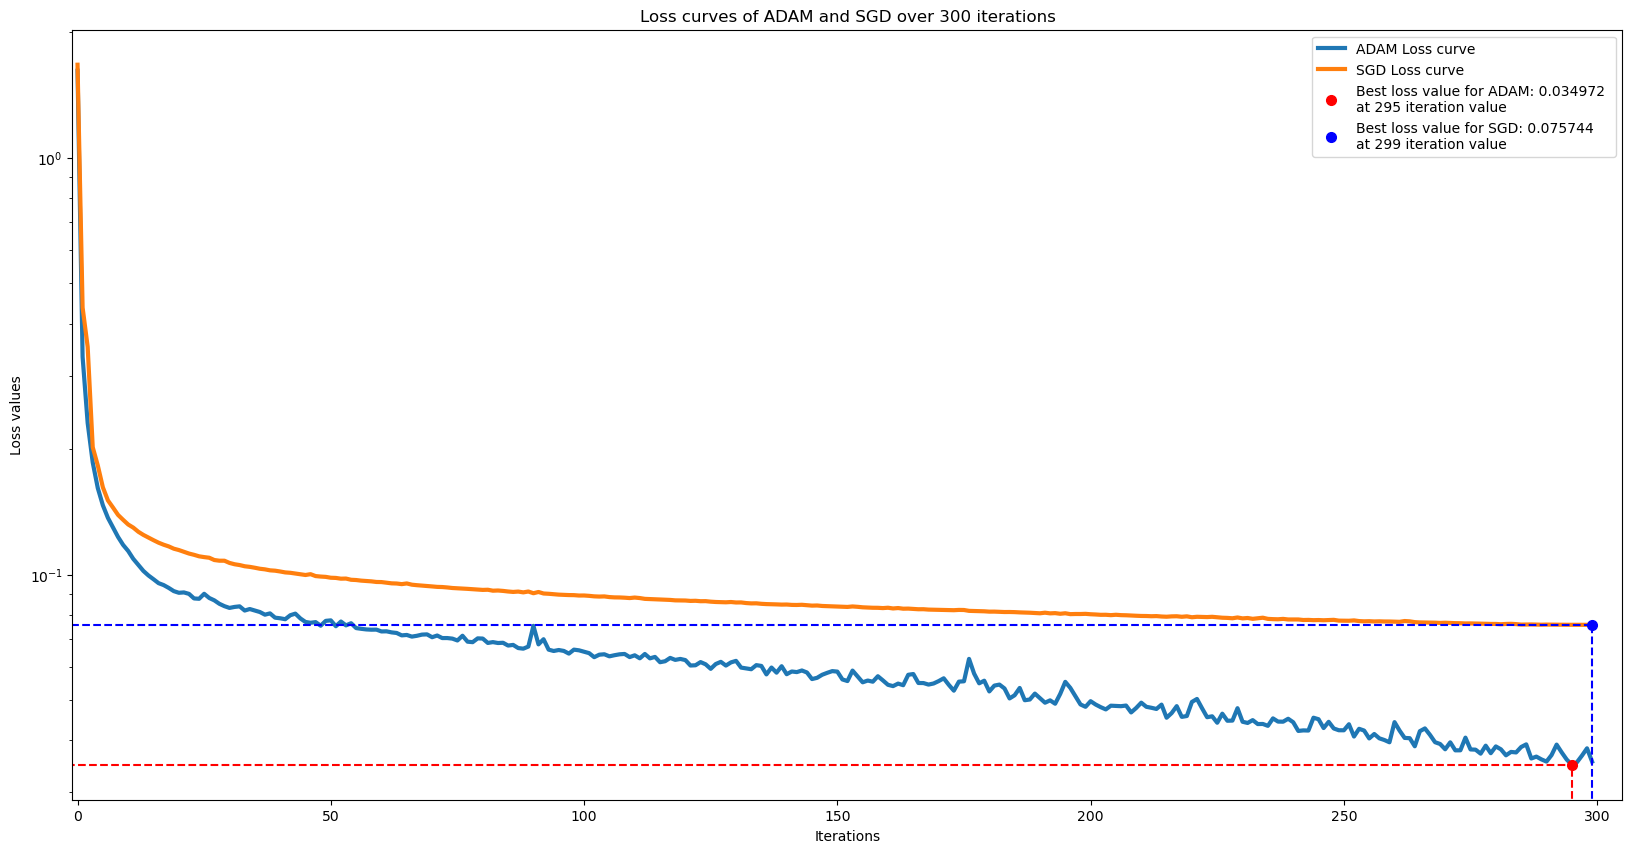

In [78]:
plt.figure(figsize=(20, 10))
plt.plot(m1_loss, label="ADAM Loss curve", linewidth=3)
plt.plot(m2_loss, label="SGD Loss curve", linewidth=3)

plt.plot(bl_i1, m1_best_loss, "ro", markersize=7,label=f"Best loss value for ADAM: {m1_best_loss:0.6f} \nat {bl_i1} iteration value")
plt.hlines(m1_best_loss, -2, bl_i1,
           colors='red', linestyles='dashed')
plt.vlines(bl_i1, 0, m1_best_loss,
           colors='red', linestyles='dashed')

plt.plot(bl_i2, m2_best_loss, "bo", markersize=7,
         label=f"Best loss value for SGD: {m2_best_loss:0.6f} \nat {bl_i2} iteration value")
plt.hlines(m2_best_loss, -10, bl_i2,
           colors='blue', linestyles='dashed')
plt.vlines(bl_i2, 0, m2_best_loss,
           colors='blue', linestyles='dashed')

plt.title("Loss curves of ADAM and SGD over 300 iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss values")
plt.yscale("log")
plt.xlim(-1, 305)
plt.legend()

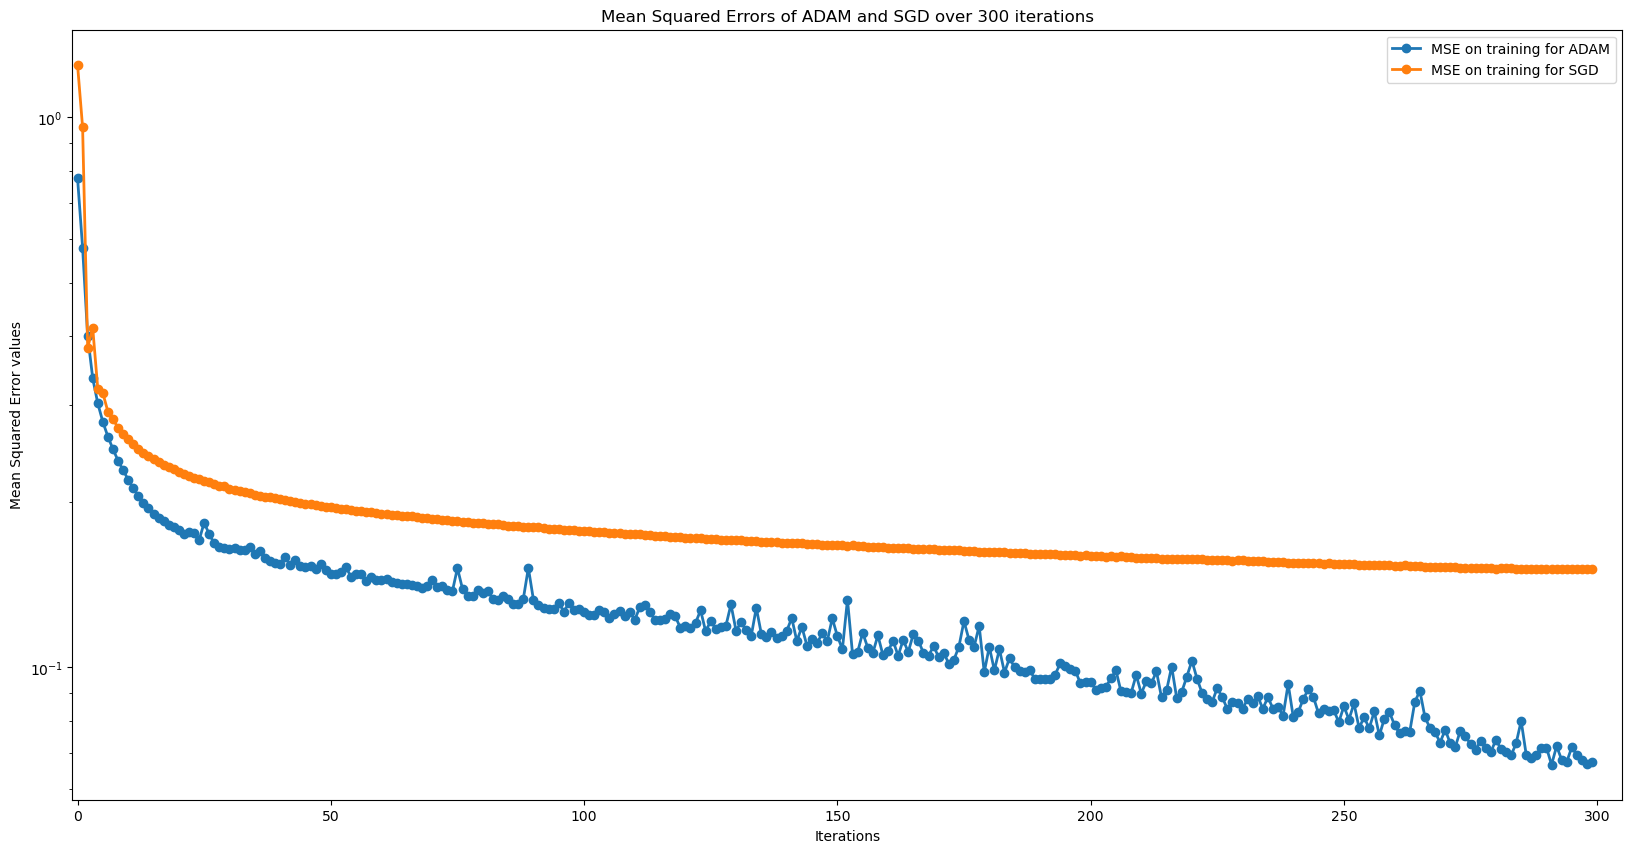

In [47]:
plt.figure(figsize=(20, 10))
plt.plot(mse_1, "o-", label="MSE on training for ADAM", linewidth=2)
plt.plot(mse_2, "o-", label="MSE on training for SGD", linewidth=2)

plt.title("Mean Squared Errors of ADAM and SGD over 300 iterations")
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error values")
plt.yscale("log")
plt.xlim(-1, 305)
plt.legend()

In [48]:
print("R^2 value for ADAM:", r2_score(test_y_reg, y1_pred), "\nR^2 value for SGD:", r2_score(test_y_reg, y2_pred))
print("MSE value for ADAM:", mean_squared_error(test_y_reg, y1_pred), "\nMSE value for SGD:", mean_squared_error(test_y_reg, y2_pred))

R^2 value for ADAM: 0.9102810631218505 
R^2 value for SGD: 0.9097705271979456
MSE value for ADAM: 0.19149761381576383 
MSE value for SGD: 0.19258731031236634


### 3.3 Report (4 Marks)
Answer the following questions in your report, to be submitted separately:
1. What conclusions can you draw based on your model selection results in Section 3.1? (2 marks)

2. Comment on the two training algorithms based on your results obtained in Section 3.2. (2 marks)

## 4.  Build A Robust MLP Regressor (6 Marks)

In this last experiment, you will develop and submit a robust MLP regressor to predict the CO(GT) value based on the other 11 variables, using the provided dataset. This robust regressor should account for the presence of missing and noisy features. 

Once you have developed your model, save it to a file using the provided `save_model` function for submission.

### 4.1 Model Development (3 Marks)

What you consider in model development should include (but not limited to) (1) handling of missing features in the unseen testing data, (2) handling of noisy features in the unseen testing data, and (3) a model selection practice.

Write your model development code below. Describe briefly in your report what you have considered in your model development.


In [49]:
# Your code here
from sklearn.metrics import mean_absolute_error

In [50]:
# Data preparation
X = sensor_data_full.drop("CO(GT)", axis=1).values
y = sensor_data_full["CO(GT)"].values

imputer = SimpleImputer(missing_values=-999,  strategy="mean")
scaler = RobustScaler()

imputed_X = imputer.fit_transform(X)
X = scaler.fit_transform(imputed_X)

In [51]:
# MLP Regressor at the best alpha value
model_main = MLPRegressor(hidden_layer_sizes=(
    100, 100), activation="relu", alpha=0.001, random_state=42, max_iter=300, warm_start=False, early_stopping=False)

In [52]:

model_main.fit(np.array(X), np.array(y))

# Model performance on entire training data
y_pred_train = model_main.predict(np.array(X))
mse_train = mean_squared_error(np.array(y), y_pred_train)
mae_train = mean_absolute_error(np.array(y), y_pred_train)
r2_score_val = r2_score(np.array(y), y_pred_train)


print("Training Set Metrics:")
print(f"R^2 score: {r2_score_val}")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Mean Absolute Error (MAE): {mae_train}")

Training Set Metrics:
R^2 score: 0.963823958018107
Mean Squared Error (MSE): 0.07131063170910516
Mean Absolute Error (MAE): 0.17316149591999047


/Users/erebus2507/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


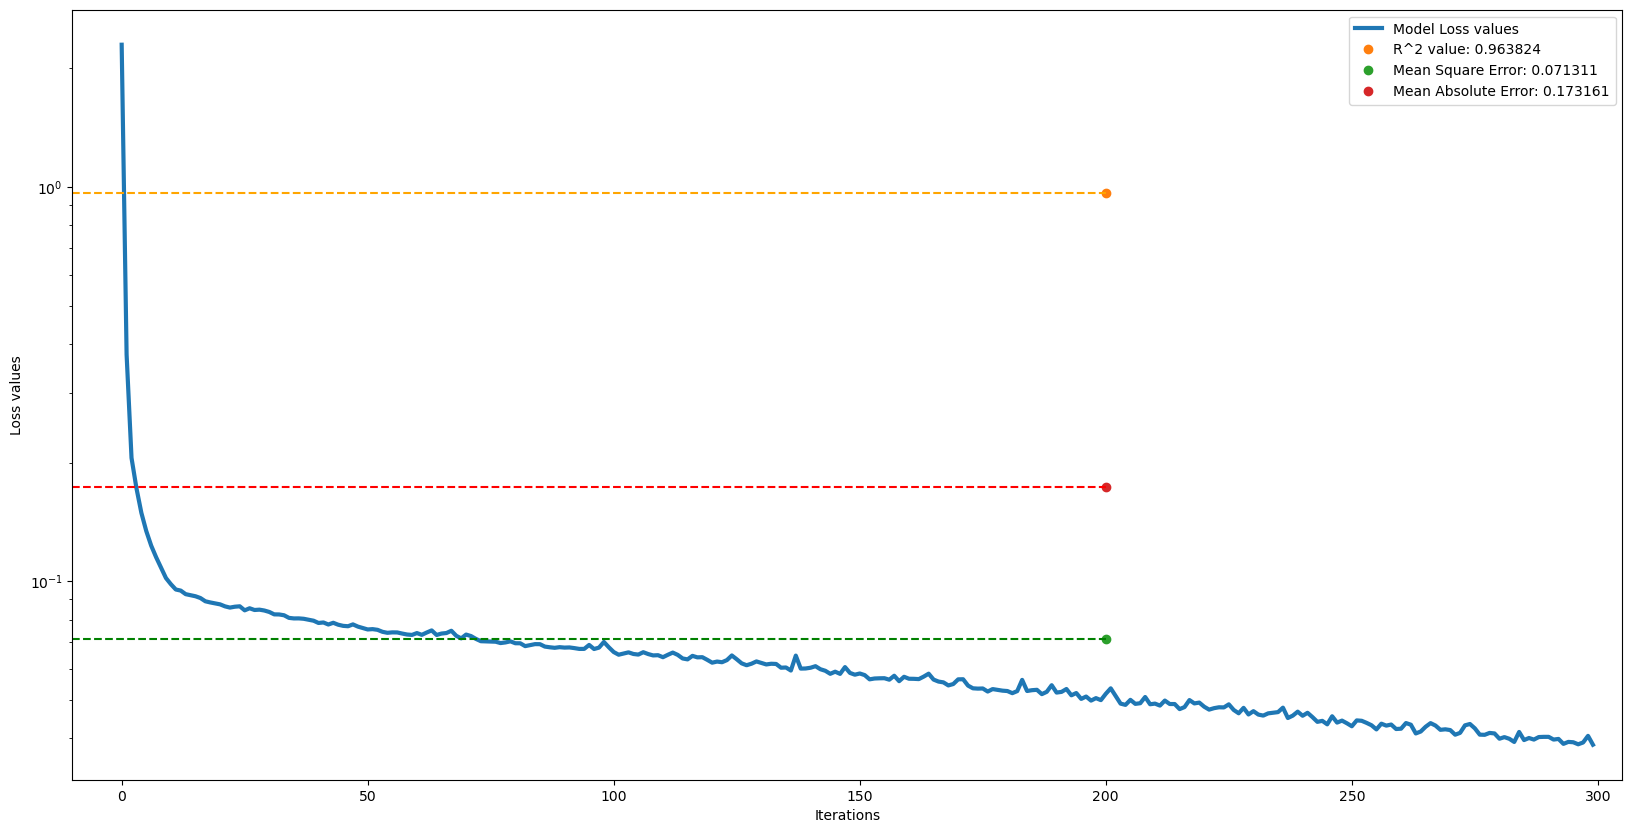

In [53]:
train_loss = model_main.loss_curve_
plt.figure(figsize=(20, 10))
plt.plot(train_loss, label="Model Loss values", linewidth=3)
plt.plot(200, (r2_score_val), "o", label=f"R^2 value: {r2_score_val:0.6f}")
plt.plot(200, mse_train, "o", label=f"Mean Square Error: {mse_train:0.6f}")
plt.plot(200, mae_train, "o", label=f"Mean Absolute Error: {mae_train:0.6f}")
plt.xlabel("Iterations")
plt.ylabel("Loss values")
plt.yscale("log")
plt.xlim(-10, 305)
plt.legend()

plt.hlines(r2_score_val, -10, 200,
           colors='orange', linestyles='dashed')
plt.hlines(mse_train, -10, 200,
           colors='green', linestyles='dashed')
plt.hlines(mae_train, -10, 200,
           colors='red', linestyles='dashed')

## 4.2 External Testing (3 Marks)
Save your trained model for submission, and submit it along with your notebook and report. It will be run and evaluated on a test set unseen by you.

**Important: set your university username (e.g. mbxxabc3) below when saving your model.** Failure to do this correctly would lead to your model not being marked!

In [54]:
import model_eval_utils

#### SAVE YOUR MODEL
student_username = "m84948am" # SET YOUR USERNAME HERE
model = model_main # SET YOUR MODEL HERE
model_eval_utils.save_model(student_username, model)

In [55]:
print(f"Total notebook run time: {time.time() - notebook_start_time:.0f} seconds")

Total notebook run time: 75 seconds


### Option to test your saved model
Use the `run_model()` function to make sure your saved model can be loaded and run before submitting.

Please note the score returned by `run_model()` is not in any way indicative of your final mark. This is just a simple test to make sure your model can be loaded and run. When testing your model, the GTA will run your model following the practice below, but replacing the bunk_data with the testing data.

In [56]:
# some bunk data
bunk_data = np.array([[ 1.22400000e+03,  9.97440117e+00,
        9.76666667e+02,  2.50600000e+02,  5.71333333e+02,
        1.30700000e+02,  1.42433333e+03,  1.00166667e+03,
        2.32666664e+01,  3.57999992e+01,  1.00855762e+00],
    [ 9.24250000e+02,   3.97337806e+00,
        7.09250000e+02,  6.30000000e+01,  1.15800000e+03,
        7.50000000e+01,  1.31800000e+03,  6.09750000e+02,
        1.60500000e+01,  4.13500004e+01,  7.48680717e-01],
    [ 8.92000000e+02,  5.06611560e+00,
        7.66750000e+02,  7.10000000e+01,  1.18000000e+03,
        8.40000000e+01,  1.46600000e+03,  6.56750000e+02,
        1.79749999e+01,  5.14499998e+01,  1.05039283e+00]])
bunk_labels = np.array([2. , 1.3, 6.1])

score = model_eval_utils.run_model(student_username, 
                                test_data=bunk_data, 
                                test_labels=bunk_labels, 
                                model_folder=".")

Attempting to load from ....
Loaded ./m84948am.sav model.
Model score: -612654.5844815635
